# Time series with Box-Cox transformation and forecasting wtih FBProhpet

#### Check that FBprophet works

Sometimes fbprophet dosent install well and the problem is related pystan not working in that case check if pystan works first before using fbprophet <br>
https://github.com/facebook/prophet/issues/1072

In [ ]:
#!pip install pystan

import pystan
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #Graphics in SVG format are more sharp and legible
import scipy.sparse
import warnings
import random

In [2]:
plt.style.use('seaborn-white') #for jupyter dark, change style
sns.set_style("darkgrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/ <br>
https://mode.com/example-gallery/forecasting_prophet_python_cookbook/#forecasting

In [4]:
import requests

print('Beginning file download with requests')

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
r = requests.get(url)

with open('data/airline-passengers.csv', 'wb') as series:
    series.write(r.content)

# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

Beginning file download with requests
200
text/plain; charset=utf-8
utf-8


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


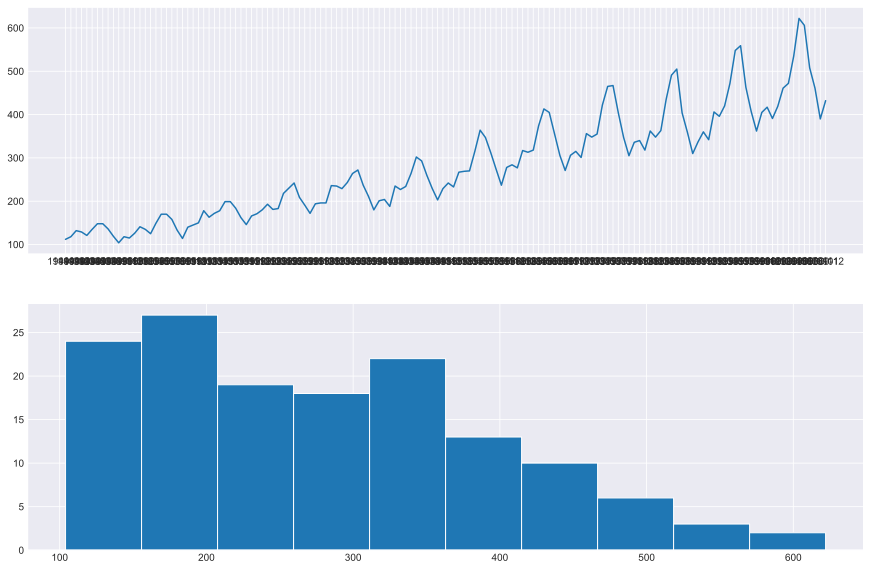

In [20]:
#better to have the indexset for the graphs
series = pd.read_csv('data/airline-passengers.csv', header=0, index_col=0) #to set index index_col=0

plt.figure(figsize=(15,10))

# line plot
plt.subplot(211)
plt.plot(series.Passengers)

# histogram
plt.subplot(212)
plt.hist(series.Passengers)
plt.show()

Non stationary data: so neural networks or arima not good. seems to have both trend and seasonality
<br>
The amount of change, or the variance, is increasing with time. This is clear when you look at the size of the seasonal
component and notice that from one cycle to the next, the amplitude (from bottom to top of the cycle) is increasing.


# Applying FBProphet to fit and predict data
FBprohpet is only useful for univariate cases

In [6]:
series = pd.read_csv('data/airline-passengers.csv', header=0, index_col=False) #to set index index=0

#Prophet always expects two columns in the input DataFrame: ds and y. 
#The ds column represents the date from your SQL query, and needs to be either date or datetime data type. 
#The y column represents the value we are looking to forecast, and must be of numeric data 
series['ds'] = series['Month']
series['y'] = series['Passengers']

#You can then repurpose the date column to be used as the index of the dataframe:
series.set_index('Month')
series.head()

,Month,Passengers,ds,y
0,1949-01,112,1949-01,112
1,1949-02,118,1949-02,118
2,1949-03,132,1949-03,132
3,1949-04,129,1949-04,129
4,1949-05,121,1949-05,121


In [7]:
from fbprophet import Prophet
m = Prophet()
m.fit(series)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
#Prophet has a built-in helper function make_future_dataframe to create a dataframe of future dates.
#The make_future_dataframe function lets you specify the frequency and number of periods you would like to forecast into the future. 
#By default, the frequency is set to days. 
#Since we are using daily periodicity data in this example, we will leave freq at it’s default and set the periods argument to 365 i.e. year into the future

# Prophet will have created a new dataframe assigned to the forecast variable that contains the forecasted values: yhat, 
#as well as uncertainty intervals and components for the forecast. We can visualize the forecast using Prophet’s built-in plot helper functio

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast.head()
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
169,1960-12-27,487.024779,416.333544,473.445968,487.024779,487.024779,-43.165360,-43.165360,-43.165360,-43.165360,-43.165360,-43.165360,0.0,0.0,0.0,443.859419
170,1960-12-28,487.125238,421.590362,478.444894,487.125238,487.125238,-38.269699,-38.269699,-38.269699,-38.269699,-38.269699,-38.269699,0.0,0.0,0.0,448.855539
171,1960-12-29,487.225698,427.032140,481.464314,487.225698,487.225698,-33.604061,-33.604061,-33.604061,-33.604061,-33.604061,-33.604061,0.0,0.0,0.0,453.621637
172,1960-12-30,487.326157,429.489907,486.507491,487.326157,487.326157,-29.269023,-29.269023,-29.269023,-29.269023,-29.269023,-29.269023,0.0,0.0,0.0,458.057134
173,1960-12-31,487.426617,432.229964,493.137225,487.426617,487.426617,-25.356311,-25.356311,-25.356311,-25.356311,-25.356311,-25.356311,0.0,0.0,0.0,462.070306


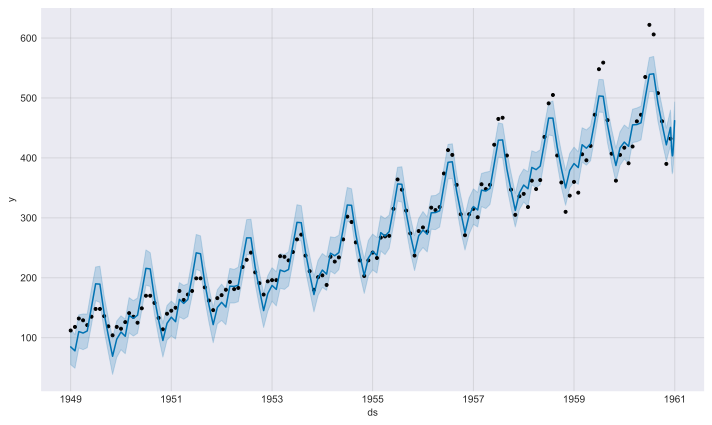

In [9]:
m.plot(forecast);

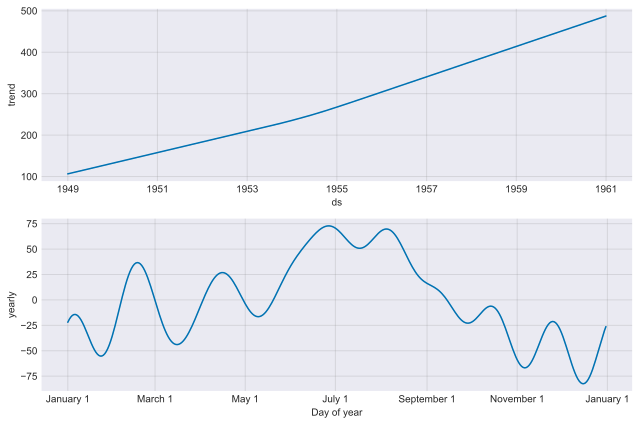

In [10]:
#If you want to visualize the individual forecast components, you can use Prophet’s built-in plot_components method:
m.plot_components(forecast);

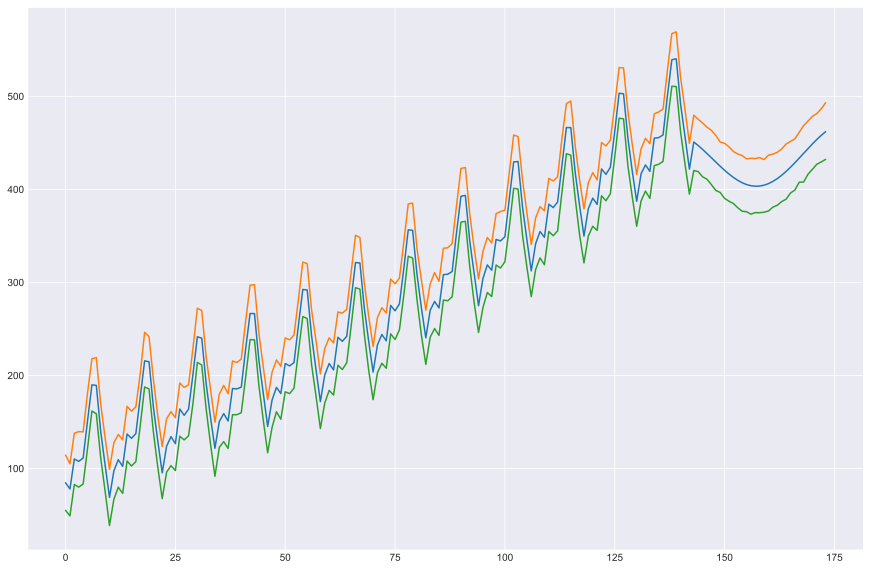

In [11]:
plt.figure(figsize=(15,10))
plt.plot(forecast[['yhat','yhat_upper','yhat_lower']]);

# Transforming using Box-Cox

Often in forecasting, a specific type of power is used transform to apply to the data to remove noise before feeding the data into a forecasting model (e.g. a log transform or square root transform, amongst others).<br>
However, it can  be difficult to determine which type is appropriate. This is where the Box-Cox Transform comes in.<br>

Box-Cox Transforms are data transformations that evaluate a set of lambda coefficients (λ) and selects the value that achieves the best approximation of normality.<br>
The boxcox method has one required input: a 1-dimensional array of positive data to transform. Optionally, you can also specify the λ value you’d like to use for your transformation (e.g. λ = 0 for a log transform).<br>
Otherwise, the boxcox method will find the λ that maximizes the log-likelihood function and will return it as the second output argument.
For our example, we will let the boxcox method determine the optimal λ to use for our transformation, and will return that value to a variable named lam:<br>

lambda = -1. is a reciprocal transform. <br>
lambda = -0.5 is a reciprocal square root transform. <br>
lambda = 0.0 is a log transform.<br>
lambda = 0.5 is a square root transform.<br>
lambda = 1.0 is no transform.<br>
<br>

Apply Box-Cox Transform to value column and assign to new column y<br>

### Box-Cox Transformation Example

Lambda: 0.148023


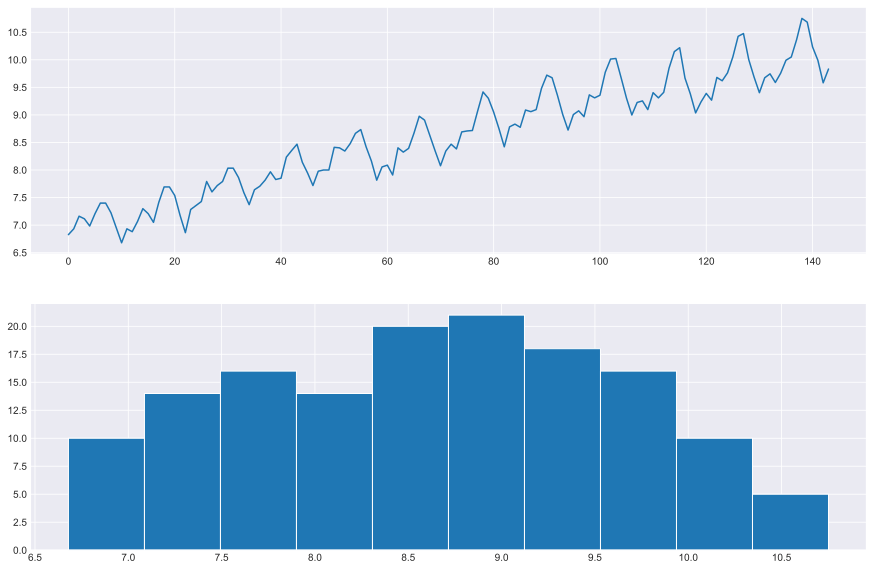

In [12]:
#better to have the indexset for the graphs
series = pd.read_csv('data/airline-passengers.csv', header=0, index_col=0) #to set index index=0

from scipy.stats import boxcox

dataframe = pd.DataFrame(series.values)
dataframe.columns = ['passengers']
dataframe['passengers'], lambda_boxcox  = boxcox(dataframe['passengers'])
print('Lambda: %f' % lambda_boxcox)

plt.figure(figsize=(15,10))

plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(dataframe['passengers'])

# histogram
plt.subplot(212)
plt.hist(dataframe['passengers'])
plt.show()

## Forecasintg with a Box-Cox Transformation using FBprophet

In [13]:
series = pd.read_csv('data/airline-passengers.csv', header=0, index_col=False) #to set index index=0

#Prophet always expects two columns in the input DataFrame: ds and y. 
#The ds column represents the date from your SQL query, and needs to be either date or datetime data type. 
#The y column represents the value we are looking to forecast, and must be of numeric data 
series['ds'] = series['Month']
series['y'] = series['Passengers']

#You can then repurpose the date column to be used as the index of the dataframe:
series.set_index('Month')
series.head()

,Month,Passengers,ds,y
0,1949-01,112,1949-01,112
1,1949-02,118,1949-02,118
2,1949-03,132,1949-03,132
3,1949-04,129,1949-04,129
4,1949-05,121,1949-05,121


In [14]:
train_df2 = series.copy().set_index('ds')

from scipy.stats import boxcox
train_df2['Passengers'] = boxcox(series['Passengers'], lmbda = 0) # need positive data
train_df2.reset_index(inplace=True)

In [15]:
from fbprophet import Prophet
m2 = Prophet()
m2.fit(series)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


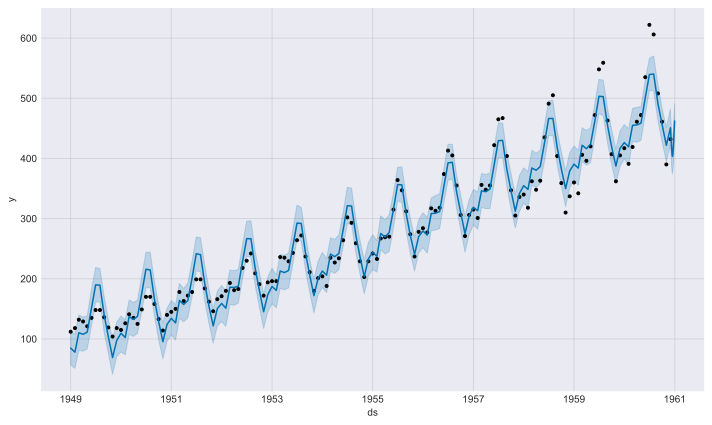

In [16]:
future2 = m2.make_future_dataframe(periods=30)
forecast2 = m2.predict(future2)
m2.plot(forecast2);

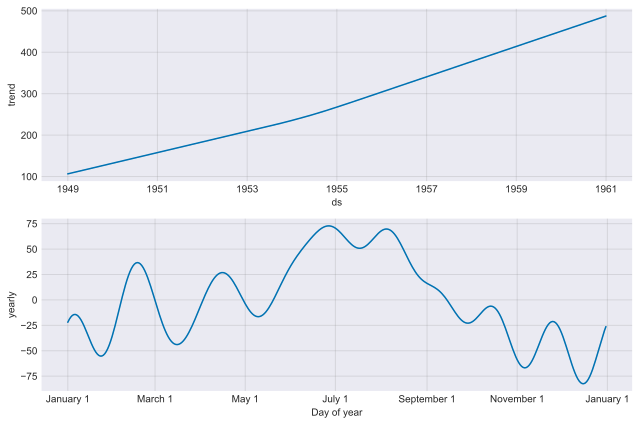

In [17]:
m2.plot_components(forecast2);

In [18]:
from scipy.special import inv_boxcox
# Apply inverse Box-Cox transform to specific forecast columns
forecast2[['yhat','yhat_upper','yhat_lower']] = forecast2[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lambda_boxcox))

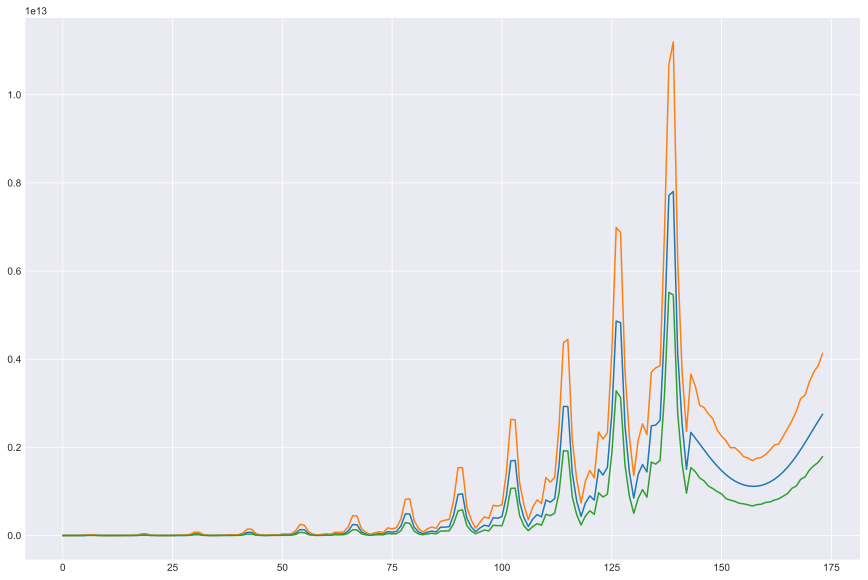

In [19]:
plt.figure(figsize=(15,10))

plt.plot(forecast2[['yhat','yhat_upper','yhat_lower']]);

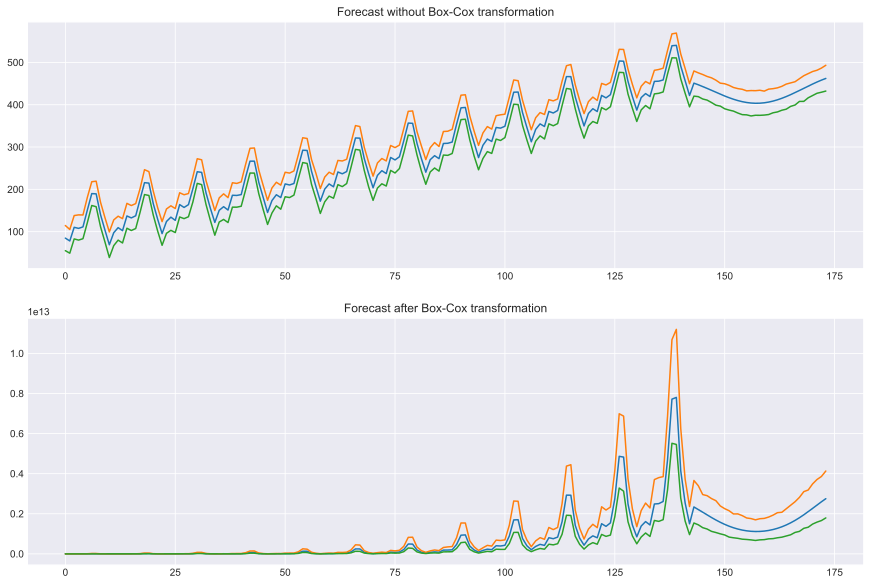

In [46]:
plt.figure(figsize=(15,10))

plt.subplot(211)
#label = forecast[['yhat','yhat_upper','yhat_lower']]
plt.title('Forecast without Box-Cox transformation', )
#plt.legend(label)
plt.plot(forecast[['yhat','yhat_upper','yhat_lower']]);

plt.subplot(212)
#label2 = forecast2[['yhat','yhat_upper','yhat_lower']]
#plt.legend(label2)
plt.title('Forecast after Box-Cox transformation', )
plt.plot(forecast2[['yhat','yhat_upper','yhat_lower']]);

*********************
# *********************